### Configuration

In [9]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import *
import sys
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import psutil

In [10]:
spark = SparkSession.builder \
    .appName("suggestify") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 200)
spark.conf.set("spark.default.parallelism", 200)

In [11]:
venv_path = os.path.dirname(os.path.dirname(sys.executable))

#conseguir direccion del proyecto, donde esta la bd
project_path = os.path.dirname(venv_path)

### Dataframe retrieval

In [12]:
sqlite_conn = sqlite3.connect(project_path+"/extracted.db") #clase
#sqlite_conn = sqlite3.connect(venv_path+"/extracted.db") #casa
#sqlite_conn = sqlite3.connect("/home/enekobarba/bigdata/extracted.db")

cursor = sqlite_conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in SQLite:", tables)

df = pd.read_sql("SELECT * FROM extracted", sqlite_conn)

sqlite_conn.close()

df.head()

Tables in SQLite: [('extracted',)]


,track_uri,track_name,artist_name,artist_uri,album_name,album_uri,duration_ms,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,fduration_ms,time_signature
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,0.904,0.813,4,...,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,0.774,0.838,5,...,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,0.664,0.759,2,...,0.0598,0.701,99.252,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,0.892,0.714,4,...,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,0.853,0.606,0,...,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4


In [13]:
df.shape

(2261644, 25)

We'll now separate the columns from which we can get insights into what relationships and patterns our data hides. This next dataframe, "df_sample_others", is the collection of columns containing uris and references, that we will maybe later on use, but for now, we'll put them aside and focus our attention into "df_sample".

Defining the track_uri as a id for each song could be a simple option, however, as it contains letters, it will later on crash. Taking that into account, we'll define a unique identifier based on the track_uri as follows:

In [14]:
df['track_id'] = df['track_uri'].astype('category').cat.codes


In [15]:
df_sample = df[["track_id", "track_name", "artist_name", "album_name", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]
df_sample_others = df[["track_id", "track_uri", "artist_uri", "album_uri", "type", "uri", "id", "fduration_ms", "track_href", "analysis_url"]]

We can now clean the data, and separate the numerical data from the categorical, using the id in both as identification

In [16]:
df_sample_numerical = df_sample[["track_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]
df_sample_categorical= df_sample[["track_id", "track_name", "artist_name", "album_name"]]

### Intento de KMeans con Pandas

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [18]:
#apply PCA
pca = PCA(n_components=4) 
df_pca = pca.fit_transform(df_sample_numerical[["duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]])

### PC1, PC2

In [19]:
#KMeans with k=10
kmeans = KMeans(n_clusters=10, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(df_pca)

/tmp/ipykernel_2903/2543915891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['cluster'] = kmeans.fit_predict(df_pca)


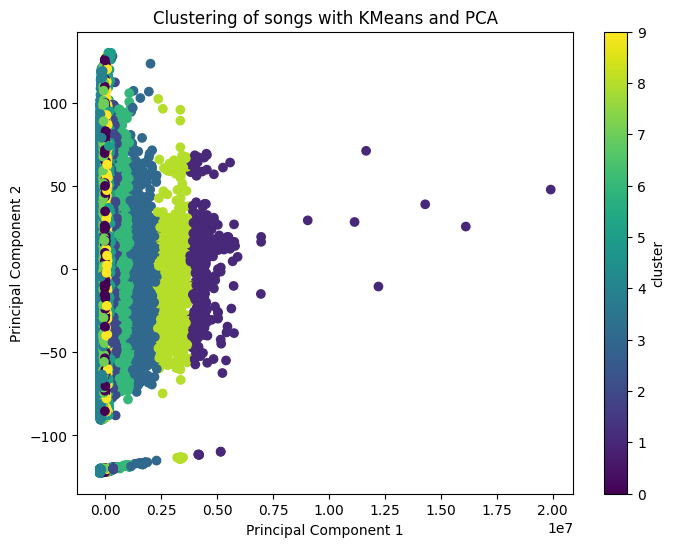

In [20]:
#visualization
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_sample['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='cluster')
plt.show()

### PC3, PC4

In [21]:
df_pca_34 = pd.DataFrame(df_pca[:, 2:], columns=['PC3', 'PC4'])

In [22]:
#KMeans with k=10
kmeans = KMeans(n_clusters=10, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(df_pca_34)

/tmp/ipykernel_2903/262397752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['cluster'] = kmeans.fit_predict(df_pca_34)


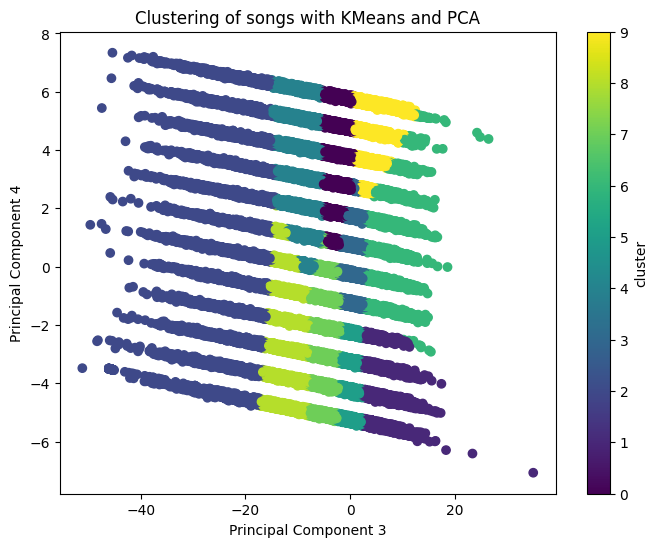

In [23]:
# Visualización corregida
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_34['PC3'], df_pca_34['PC4'], c=df_sample['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and PCA')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.colorbar(label='cluster')
plt.show()

### TSNE

In [ ]:
#apply TSNE
tsne = TSNE(n_components=4) 
df_tsne = tsne.fit_transform(df_sample_numerical[["duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]])

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(df_tsne)

In [ ]:
#visualization
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df_sample['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and TSNE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='cluster')
plt.show()

# Spark

### Spark Dataframe

In [ ]:
#columns for clustering
feature_columns = ["danceability", "energy", "key", "loudness", "mode",
                   "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")
assembled_df = assembler.transform(spark_df).repartition(500).cache()
assembled_df.count()

25/03/14 10:01:04 WARN TaskSetManager: Stage 1 contains a task of very large size (12366 KiB). The maximum recommended task size is 1000 KiB.


2261644

### Intento de KMeans con Spark

In [ ]:
schema = StructType([
    StructField("track_uri", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("artist_name", StringType(), True),
    StructField("album_name", StringType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("danceability", FloatType(), True),
    StructField("energy", FloatType(), True),
    StructField("key", IntegerType(), True),
    StructField("loudness", FloatType(), True),
    StructField("mode", IntegerType(), True),
    StructField("speechiness", FloatType(), True),
    StructField("acousticness", FloatType(), True),
    StructField("instrumentalness", FloatType(), True),
    StructField("liveness", FloatType(), True),
    StructField("valence", FloatType(), True),
    StructField("tempo", FloatType(), True),
    StructField("time_signature", IntegerType(), True)
])

spark_df = spark.createDataFrame(df_sample, schema=schema)

spark_df.show(5)

25/03/14 10:01:03 WARN TaskSetManager: Stage 0 contains a task of very large size (12366 KiB). The maximum recommended task size is 1000 KiB.


+---------+--------------------+-----------------+--------------------+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|track_uri|          track_name|      artist_name|          album_name|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+---------+--------------------+-----------------+--------------------+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|   143810|Lose Control (fea...|    Missy Elliott|        The Cookbook|     226863|       0.904| 0.813|  4|  -7.105|   0|      0.121|      0.0311|         0.00697|  0.0471|   0.81|125.461|             4|
|  1827850|               Toxic|   Britney Spears|         In The Zone|     198800|       0.774| 0.838|  5|  -3.914|   0|      0.114|      0.0249|           0.025|   0.242|  0.924| 143

In [ ]:
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df).select("features").cache()
scaled_df.count()

2261644

In [ ]:
#KMeans with 10 clusters
kmeans = KMeans(k=10, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(scaled_df)

25/03/14 10:01:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [ ]:
#predictions
clustered_df = model.transform(assembled_df)

In [ ]:
#plotting the clusters
pandas_df = clusters_df.select("danceability", "energy", "cluster").toPandas() #transform to pandas for plotting
plt.figure(figsize=(10, 6))
for cluster in range(10):
    cluster_data = pandas_df[pandas_df['cluster'] == cluster]
    plt.scatter(cluster_data['danceability'], cluster_data['energy'], label=f'Cluster {cluster}')

plt.title('Clustering de canciones por danceability y energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.legend()
plt.show()